# Radial Basis Function (RBF) Network for Handwritten CharacterRecognition

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

Loading Dataset

In [2]:
(train_data, test_data), ds_info = tfds.load('kmnist', split=['train', 'test'], shuffle_files=True, as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/kmnist/incomplete.LYPDCQ_3.0.1/kmnist-train.tfrecord*...:   0%|          |…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/kmnist/incomplete.LYPDCQ_3.0.1/kmnist-test.tfrecord*...:   0%|          | …

Dataset kmnist downloaded and prepared to /root/tensorflow_datasets/kmnist/3.0.1. Subsequent calls will reuse this data.


# **Preprocess the data**

In [3]:
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

(train_data, test_data), ds_info = tfds.load('kmnist', split=['train', 'test'], shuffle_files=True, as_supervised=True, with_info=True)

train_data = train_data.map(preprocess).batch(128).prefetch(tf.data.AUTOTUNE)
test_data = test_data.map(preprocess).batch(128).prefetch(tf.data.AUTOTUNE)

**Convert dataset to numpy arrays**

In [4]:
def dataset_to_numpy(dataset):
    images, labels = [], []
    for image_batch, label_batch in dataset:
        images.append(image_batch.numpy())
        labels.append(label_batch.numpy())
    return np.concatenate(images), np.concatenate(labels)

X_train, y_train = dataset_to_numpy(train_data)
X_test, y_test = dataset_to_numpy(test_data)

**Reshape the images**

In [5]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

# **Radial Basis Function (RBF) Network**

In [6]:
class RBFLayer(tf.keras.layers.Layer):
    def __init__(self, num_outputs, centers):
        super(RBFLayer, self).__init__()
        self.num_outputs = num_outputs
        self.centers = centers

    def build(self, input_shape):
        self.betas = self.add_weight(name='betas', shape=(self.num_outputs,),
                                     initializer='ones', trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        C = tf.expand_dims(self.centers, axis=0)
        H = tf.transpose(C - tf.expand_dims(inputs, axis=1), perm=[0, 2, 1])
        return tf.exp(-self.betas * tf.reduce_sum(H**2, axis=1))

#**Training**

**Using K-means to determine RBF centers**

In [7]:
num_rbf = 100
kmeans = KMeans(n_clusters=num_rbf, n_init=10)
kmeans.fit(X_train)
rbf_centers = kmeans.cluster_centers_

**Building the model**

In [8]:
model = tf.keras.Sequential([
    RBFLayer(num_rbf, rbf_centers),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

**Train the model**

In [16]:
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, verbose=1)

Epoch 1/100
1500/1500 [==============================] - 7s 5ms/step - loss: 1.8661 - accuracy: 0.3140 - val_loss: 1.8658 - val_accuracy: 0.3315
Epoch 2/100
1500/1500 [==============================] - 7s 5ms/step - loss: 1.8704 - accuracy: 0.3145 - val_loss: 1.9568 - val_accuracy: 0.2563
Epoch 3/100
1500/1500 [==============================] - 7s 4ms/step - loss: 1.8737 - accuracy: 0.3145 - val_loss: 1.9679 - val_accuracy: 0.2422
Epoch 4/100
1500/1500 [==============================] - 7s 4ms/step - loss: 1.8746 - accuracy: 0.3125 - val_loss: 1.8490 - val_accuracy: 0.3209
Epoch 5/100
1500/1500 [==============================] - 7s 4ms/step - loss: 1.8795 - accuracy: 0.3083 - val_loss: 1.8646 - val_accuracy: 0.3147
Epoch 6/100
1500/1500 [==============================] - 7s 5ms/step - loss: 1.8755 - accuracy: 0.3143 - val_loss: 1.8900 - val_accuracy: 0.2970
Epoch 7/100
1500/1500 [==============================] - 7s 5ms/step - loss: 1.8770 - accuracy: 0.3134 - val_loss: 1.9819 - val_ac

# **Evaluation**

In [17]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc:.4f}")

Test accuracy: 0.1884


In [18]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
conf_mat = confusion_matrix(y_test, y_pred_classes)

313/313 [==============================] - 1s 3ms/step


**Visualizing the Confusion Matrix**

Text(95.72222222222221, 0.5, 'True')

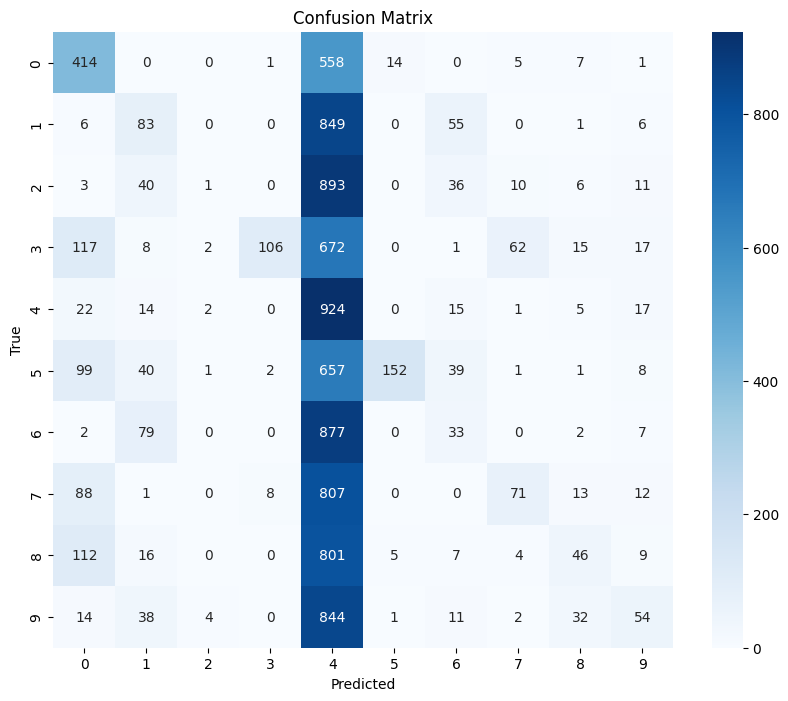

In [19]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

**Visualizing the training history**

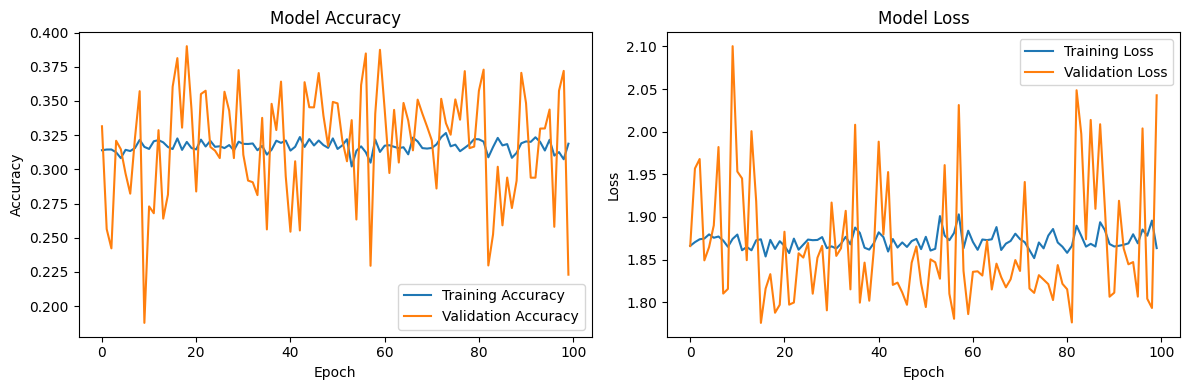

In [20]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# **Analysis**

In [21]:
print("Analysis:")
print("Strengths of RBF Network:")
print("1. Can model complex non-linear decision boundaries")
print("2. Faster training compared to some other neural network architectures")
print("3. Good at handling localized features in the input space")

print("\nLimitations of RBF Network:")
print("1. Performance heavily depends on the choice of centers")
print("2. May require a large number of RBF units for complex problems")
print("3. Can be sensitive to the scale of the input features")

print("\nEffect of number of RBF units:")
print("Increasing the number of RBF units can improve the model's ability to capture complex patterns,")
print("but it also increases computational cost and may lead to overfitting if too many units are used.")
print("Finding the optimal number often requires experimentation and cross-validation.")

Analysis:
Strengths of RBF Network:
1. Can model complex non-linear decision boundaries
2. Faster training compared to some other neural network architectures
3. Good at handling localized features in the input space

Limitations of RBF Network:
1. Performance heavily depends on the choice of centers
2. May require a large number of RBF units for complex problems
3. Can be sensitive to the scale of the input features

Effect of number of RBF units:
Increasing the number of RBF units can improve the model's ability to capture complex patterns,
but it also increases computational cost and may lead to overfitting if too many units are used.
Finding the optimal number often requires experimentation and cross-validation.
